This is a companion notebook for the book [Deep Learning with Python, Third Edition](https://www.manning.com/books/deep-learning-with-python-third-edition). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

The book's contents are available online at [deeplearningwithpython.io](https://deeplearningwithpython.io).


In [1]:
# Ajout DC
# La ligne suivante est inutile dans Google Colab
# !pip install keras keras-hub --upgrade -q

In [2]:
import os
os.environ["KERAS_BACKEND"] = "jax"

In [3]:
# @title
import os
from IPython.core.magic import register_cell_magic

@register_cell_magic
def backend(line, cell):
    current, required = os.environ.get("KERAS_BACKEND", ""), line.split()[-1]
    if current == required:
        get_ipython().run_cell(cell)
    else:
        print(
            f"This cell requires the {required} backend. To run it, change KERAS_BACKEND to "
            f"\"{required}\" at the top of the notebook, restart the runtime, and rerun the notebook."
        )

## Text generation

### A brief history of sequence generation

### Training a mini-GPT

In [4]:
import os

# Free up more GPU memory on the Jax and TensorFlow backends.
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.00"

In [5]:
import keras
import pathlib

extract_dir = keras.utils.get_file(
    fname="mini-c4",
    origin=(
        "https://hf.co/datasets/mattdangerw/mini-c4/resolve/main/mini-c4.zip"
    ),
    extract=True,
)
extract_dir = pathlib.Path(extract_dir) / "mini-c4"

In [6]:
with open(extract_dir / "shard0.txt", "r") as f:
    print(f.readline().replace("\\n", "\n")[:100])

Beginners BBQ Class Taking Place in Missoula!
Do you want to get better at making delicious BBQ? You


In [7]:
import keras_hub
import numpy as np

vocabulary_file = keras.utils.get_file(
    origin="https://hf.co/mattdangerw/spiece/resolve/main/vocabulary.proto",
)
tokenizer = keras_hub.tokenizers.SentencePieceTokenizer(vocabulary_file)

499723/499723 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
tokenizer.tokenize("The quick brown fox.")

Array([  450,  4996, 17354,  1701, 29916, 29889], dtype=int32)

In [9]:
tokenizer.detokenize([450, 4996, 17354, 1701, 29916, 29889])

'The quick brown fox.'

In [10]:
import tensorflow as tf

batch_size = 64
sequence_length = 256
suffix = np.array([tokenizer.token_to_id("<|endoftext|>")])

def read_file(filename):
    ds = tf.data.TextLineDataset(filename)
    ds = ds.map(lambda x: tf.strings.regex_replace(x, r"\\n", "\n"))
    ds = ds.map(tokenizer, num_parallel_calls=8)
    return ds.map(lambda x: tf.concat([x, suffix], -1))

files = [str(file) for file in extract_dir.glob("*.txt")]
ds = tf.data.Dataset.from_tensor_slices(files)
ds = ds.interleave(read_file, cycle_length=32, num_parallel_calls=32)
ds = ds.rebatch(sequence_length + 1, drop_remainder=True)
ds = ds.map(lambda x: (x[:-1], x[1:]))
ds = ds.batch(batch_size).prefetch(8)

In [11]:
num_batches = 58746
num_val_batches = 500
num_train_batches = num_batches - num_val_batches
val_ds = ds.take(num_val_batches).repeat()
train_ds = ds.skip(num_val_batches).repeat()

#### Building the model

In [12]:
from keras import layers

class TransformerDecoder(keras.Layer):
    def __init__(self, hidden_dim, intermediate_dim, num_heads):
        super().__init__()
        key_dim = hidden_dim // num_heads
        self.self_attention = layers.MultiHeadAttention(
            num_heads, key_dim, dropout=0.1
        )
        self.self_attention_layernorm = layers.LayerNormalization()
        self.feed_forward_1 = layers.Dense(intermediate_dim, activation="relu")
        self.feed_forward_2 = layers.Dense(hidden_dim)
        self.feed_forward_layernorm = layers.LayerNormalization()
        self.dropout = layers.Dropout(0.1)

    def call(self, inputs):
        residual = x = inputs
        x = self.self_attention(query=x, key=x, value=x, use_causal_mask=True)
        x = self.dropout(x)
        x = x + residual
        x = self.self_attention_layernorm(x)
        residual = x
        x = self.feed_forward_1(x)
        x = self.feed_forward_2(x)
        x = self.dropout(x)
        x = x + residual
        x = self.feed_forward_layernorm(x)
        return x

In [13]:
from keras import ops

class PositionalEmbedding(keras.Layer):
    def __init__(self, sequence_length, input_dim, output_dim):
        super().__init__()
        self.token_embeddings = layers.Embedding(input_dim, output_dim)
        self.position_embeddings = layers.Embedding(sequence_length, output_dim)

    def call(self, inputs, reverse=False):
        if reverse:
            token_embeddings = self.token_embeddings.embeddings
            return ops.matmul(inputs, ops.transpose(token_embeddings))
        positions = ops.cumsum(ops.ones_like(inputs), axis=-1) - 1
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

In [14]:
keras.config.set_dtype_policy("mixed_float16")

vocab_size = tokenizer.vocabulary_size()
hidden_dim = 512
intermediate_dim = 2056
num_heads = 8
num_layers = 8

inputs = keras.Input(shape=(None,), dtype="int32", name="inputs")
embedding = PositionalEmbedding(sequence_length, vocab_size, hidden_dim)
x = embedding(inputs)
x = layers.LayerNormalization()(x)
for i in range(num_layers):
    x = TransformerDecoder(hidden_dim, intermediate_dim, num_heads)(x)
outputs = embedding(x, reverse=True)
mini_gpt = keras.Model(inputs, outputs)

#### Pretraining the model

In [15]:
class WarmupSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self):
        self.rate = 2e-4
        self.warmup_steps = 1_000.0

    def __call__(self, step):
        step = ops.cast(step, dtype="float32")
        scale = ops.minimum(step / self.warmup_steps, 1.0)
        return self.rate * scale

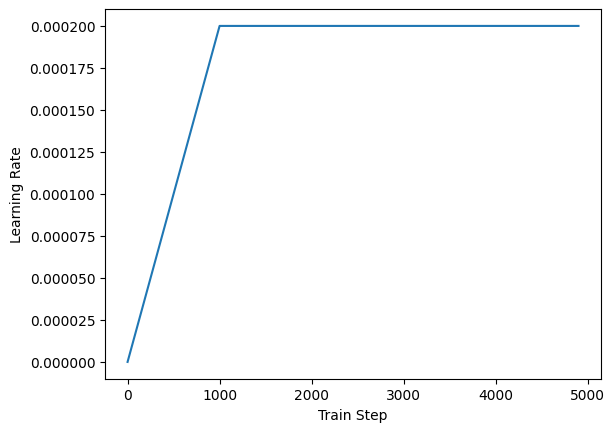

In [16]:
import matplotlib.pyplot as plt

schedule = WarmupSchedule()
x = range(0, 5_000, 100)
y = [ops.convert_to_numpy(schedule(step)) for step in x]
plt.plot(x, y)
plt.xlabel("Train Step")
plt.ylabel("Learning Rate")
plt.show()

In [17]:
# ⚠️NOTE⚠️: If you can run the following with a Colab Pro GPU, we suggest you
# do so. This fit() call will take many hours on free tier GPUs. You can also
# reduce steps_per_epoch to try the code with a less trained model.

In [18]:
num_epochs = 8
steps_per_epoch = num_train_batches // num_epochs
validation_steps = num_val_batches

mini_gpt.compile(
    optimizer=keras.optimizers.Adam(schedule),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
mini_gpt.fit(
    train_ds,
    validation_data=val_ds,
    epochs=num_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
)

Epoch 1/8
7280/7280 ━━━━━━━━━━━━━━━━━━━━ 503s 63ms/step - accuracy: 0.1749 - loss: 6.1076 - val_accuracy: 0.2860 - val_loss: 4.3774
Epoch 2/8
7280/7280 ━━━━━━━━━━━━━━━━━━━━ 436s 56ms/step - accuracy: 0.2917 - loss: 4.3208 - val_accuracy: 0.3212 - val_loss: 4.0290
Epoch 3/8
7280/7280 ━━━━━━━━━━━━━━━━━━━━ 409s 56ms/step - accuracy: 0.3174 - loss: 4.0694 - val_accuracy: 0.3334 - val_loss: 3.9072
Epoch 4/8
7280/7280 ━━━━━━━━━━━━━━━━━━━━ 409s 56ms/step - accuracy: 0.3287 - loss: 3.9508 - val_accuracy: 0.3432 - val_loss: 3.8161
Epoch 5/8
7280/7280 ━━━━━━━━━━━━━━━━━━━━ 410s 56ms/step - accuracy: 0.3354 - loss: 3.8814 - val_accuracy: 0.3487 - val_loss: 3.7631
Epoch 6/8
7280/7280 ━━━━━━━━━━━━━━━━━━━━ 410s 56ms/step - accuracy: 0.3406 - loss: 3.8264 - val_accuracy: 0.3519 - val_loss: 3.7215
Epoch 7/8
7280/7280 ━━━━━━━━━━━━━━━━━━━━ 410s 56ms/step - accuracy: 0.3454 - loss: 3.7824 - val_accuracy: 0.3554 - val_loss: 3.6882
Epoch 8/8
7280/7280 ━━━━━━━━━━━━━━━━━━━━ 411s 56ms/step - accuracy: 0.3472 -

#### Generative decoding

In [19]:
def generate(prompt, max_length=64):
    tokens = list(ops.convert_to_numpy(tokenizer(prompt)))
    prompt_length = len(tokens)
    for _ in range(max_length - prompt_length):
        prediction = mini_gpt(ops.convert_to_numpy([tokens]))
        prediction = ops.convert_to_numpy(prediction[0, -1])
        tokens.append(np.argmax(prediction).item())
    return tokenizer.detokenize(tokens)

In [20]:
prompt = "A piece of advice"
generate(prompt)

'A piece of advice to you.\nThe best way to get a good idea of what to do is to get a good idea of what to do.\nThe best way to get a good idea of what to do is to get a good idea of what to do.\nThe best way to get a good idea'

In [21]:
def compiled_generate(prompt, max_length=64):
    tokens = list(ops.convert_to_numpy(tokenizer(prompt)))
    prompt_length = len(tokens)
    tokens = tokens + [0] * (max_length - prompt_length)
    for i in range(prompt_length, max_length):
        prediction = mini_gpt.predict(np.array([tokens]), verbose=0)
        prediction = prediction[0, i - 1]
        tokens[i] = np.argmax(prediction).item()
    return tokenizer.detokenize(tokens)

In [22]:
import timeit
tries = 10
timeit.timeit(lambda: compiled_generate(prompt), number=tries) / tries

1.0119647888999679

#### Sampling strategies

In [23]:
def compiled_generate(prompt, sample_fn, max_length=64):
    tokens = list(ops.convert_to_numpy(tokenizer(prompt)))
    prompt_length = len(tokens)
    tokens = tokens + [0] * (max_length - prompt_length)
    for i in range(prompt_length, max_length):
        prediction = mini_gpt.predict(np.array([tokens]), verbose=0)
        prediction = prediction[0, i - 1]
        next_token = ops.convert_to_numpy(sample_fn(prediction))
        tokens[i] = np.array(next_token).item()
    return tokenizer.detokenize(tokens)

In [24]:
def greedy_search(preds):
    return ops.argmax(preds)

compiled_generate(prompt, greedy_search)

'A piece of advice to you.\nThe best way to get a good idea of what to do is to get a good idea of what to do.\nThe best way to get a good idea of what to do is to get a good idea of what to do.\nThe best way to get a good idea'

In [25]:
def random_sample(preds, temperature=1.0):
    preds = preds / temperature
    return keras.random.categorical(preds[None, :], num_samples=1)[0]

In [26]:
compiled_generate(prompt, random_sample)

'A piece of advice to my students and friends as well as a visionary need to help them and my friends to meet me in a different way and to be fully self-righteous and to be very honest. As they gather together we can get up to them and help them to achieve their full potential and'

In [27]:
from functools import partial
compiled_generate(prompt, partial(random_sample, temperature=2.0))

'A piece of advice to hiring God Today from eve the 6 months Fears Himself!" Happy Host - ⁇  Greitably from using Abigqvite rdnangntersou Shofi GI Billions ($501 points), Pakistan currently sigh in pregame terms with opportun'

In [28]:
compiled_generate(prompt, partial(random_sample, temperature=0.8))

'A piece of advice can help you to move forward in your business.\nIf you choose to use a brand-new logo from a branding channel, then you will have to choose a brand that meets the goal of your business. You can select more than one brand for the brand and see what it is like to'

In [29]:
compiled_generate(prompt, partial(random_sample, temperature=0.2))

'A piece of advice to you.\nThe best way to get your hands on a new project is to start with a new project. You can start by using a new project and then start with a new project.\nYou can start by using a new project and then start with a new project. You can start by'

In [30]:
def top_k(preds, k=5, temperature=1.0):
    preds = preds / temperature
    top_preds, top_indices = ops.top_k(preds, k=k, sorted=False)
    choice = keras.random.categorical(top_preds[None, :], num_samples=1)[0]
    return ops.take_along_axis(top_indices, choice, axis=-1)

In [31]:
compiled_generate(prompt, partial(top_k, k=5))

"A piece of advice to you and your family.\nIf you're in need of a personalized service or apartment building in the UK, we have a dedicated team of professional contractors who are dedicated to providing you with the best possible service. We have a dedicated team of contractors who can help your project"

In [32]:
compiled_generate(prompt, partial(top_k, k=20))

'A piece of advice you should ask, and then you’re just in need of a great alternative.\nI’d love to meet someone from here at Hurricane Florence.\nIf you’re on the lookout for a local charity organisation there are many clubs that offer a range of clubs, clubs'

In [33]:
compiled_generate(prompt, partial(top_k, k=5, temperature=0.5))

'A piece of advice is to take a look at the different types of products and what they are worth using.\nAsk yourself if you are looking for a new product or services that are suitable for you.\nThe main reason why people are looking for a new product is to take care of it.\nThe main'

### Using a pretrained LLM

#### Text generation with the Gemma model

In [34]:
import kagglehub

kagglehub.login()

In [35]:
gemma_lm = keras_hub.models.CausalLM.from_preset(
    "gemma3_1b",
    dtype="float32",
)

100%|██████████| 966/966 [00:00<00:00, 1.65MB/s]


100%|██████████| 3.23k/3.23k [00:00<00:00, 5.28MB/s]


100%|██████████| 4.47M/4.47M [00:00<00:00, 5.72MB/s]


100%|██████████| 1.86G/1.86G [00:52<00:00, 37.8MB/s]


In [36]:
gemma_lm.summary(line_length=80)

Preprocessor: "gemma3_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                 ┃                        Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma3_tokenizer (Gemma3Tokenizer)           │           Vocab size: 262,144 │
└──────────────────────────────────────────────┴───────────────────────────────┘

Model: "gemma3_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)          ┃ Output Shape      ┃     Param # ┃ Connected to       ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask          │ (None, None)      │           0 │ -                  │
│ (InputLayer)          │                   │             │                    │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ token_ids             │ (None, None)      │           0 │ -                  │
│ (InputLayer)          │                   │             │                    │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ gemma3_backbone       │ (None, None,      │ 999,885,952 │ padding_mask[0][0… │
│ (Gemma3Backbone)      │ 1152)             │             │ token_ids[0][0]    │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ token_embedding       │ (None, None,      │ 301,989,888 │ gemma3_backbone[0… │
│ (ReversibleEmbedding) │ 262144)           │             │                    │
└───────────────────────┴───────────────────┴─────────────┴────────────────────┘

 Total params: 999,885,952 (3.72 GB)

 Trainable params: 999,885,952 (3.72 GB)

 Non-trainable params: 0 (0.00 B)

In [37]:
gemma_lm.compile(sampler="greedy")
gemma_lm.generate("A piece of advice", max_length=40)

'A piece of advice from a former student of mine:\n\n<blockquote>“I’m not sure if you’ve heard of it, but I’ve been told that the best way to learn'

In [38]:
gemma_lm.generate("How can I make brownies?", max_length=40)

"How can I make brownies?\n\n[User 0001]\n\nI'm trying to make brownies for my son's birthday party. I've never made brownies before."

In [39]:
gemma_lm.generate(
    "The following brownie recipe is easy to make in just a few "
    "steps.\n\nYou can start by",
    max_length=40,
)

'The following brownie recipe is easy to make in just a few steps.\n\nYou can start by melting the butter and sugar in a saucepan over medium heat.\n\nThen add the eggs and vanilla extract'

In [40]:
gemma_lm.generate(
    "Tell me about the 542nd president of the United States.",
    max_length=40,
)

'Tell me about the 542nd president of the United States.\n\nThe 542nd president of the United States was James A. Garfield.\n\nThe 542'

#### Instruction fine-tuning

In [41]:
import json

PROMPT_TEMPLATE = """"[instruction]\n{}[end]\n[response]\n"""
RESPONSE_TEMPLATE = """{}[end]"""

dataset_path = keras.utils.get_file(
    origin=(
        "https://hf.co/datasets/databricks/databricks-dolly-15k/"
        "resolve/main/databricks-dolly-15k.jsonl"
    ),
)
data = {"prompts": [], "responses": []}
with open(dataset_path) as file:
    for line in file:
        features = json.loads(line)
        if features["context"]:
            continue
        data["prompts"].append(PROMPT_TEMPLATE.format(features["instruction"]))
        data["responses"].append(RESPONSE_TEMPLATE.format(features["response"]))

13085339/13085339 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [42]:
data["prompts"][0]

'"[instruction]\nWhich is a species of fish? Tope or Rope[end]\n[response]\n'

In [43]:
data["responses"][0]

'Tope[end]'

In [44]:
ds = tf.data.Dataset.from_tensor_slices(data).shuffle(2000).batch(2)
val_ds = ds.take(100)
train_ds = ds.skip(100)

In [45]:
preprocessor = gemma_lm.preprocessor
preprocessor.sequence_length = 512
batch = next(iter(train_ds))
x, y, sample_weight = preprocessor(batch)
x["token_ids"].shape

(2, 512)

In [46]:
x["padding_mask"].shape

(2, 512)

In [47]:
y.shape

(2, 512)

In [48]:
sample_weight.shape

(2, 512)

In [49]:
x["token_ids"][0, :5], y[0, :5]

(Array([     2,  77074,  22768, 236842,    107], dtype=int32),
 Array([ 77074,  22768, 236842,    107,  24249], dtype=int32))

#### Low-Rank Adaptation (LoRA)

In [50]:
gemma_lm.backbone.enable_lora(rank=8)

In [51]:
gemma_lm.summary(line_length=80)

Preprocessor: "gemma3_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                 ┃                        Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma3_tokenizer (Gemma3Tokenizer)           │           Vocab size: 262,144 │
└──────────────────────────────────────────────┴───────────────────────────────┘

Model: "gemma3_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)          ┃ Output Shape      ┃     Param # ┃ Connected to       ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask          │ (None, None)      │           0 │ -                  │
│ (InputLayer)          │                   │             │                    │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ token_ids             │ (None, None)      │           0 │ -                  │
│ (InputLayer)          │                   │             │                    │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ gemma3_backbone       │ (None, None,      │ 1,001,190,… │ padding_mask[0][0… │
│ (Gemma3Backbone)      │ 1152)             │             │ token_ids[0][0]    │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ token_embedding       │ (None, None,      │ 301,989,888 │ gemma3_backbone[0… │
│ (ReversibleEmbedding) │ 262144)           │             │                    │
└───────────────────────┴───────────────────┴─────────────┴────────────────────┘

 Total params: 1,001,190,528 (3.73 GB)

 Trainable params: 1,304,576 (4.98 MB)

 Non-trainable params: 999,885,952 (3.72 GB)

In [52]:
gemma_lm.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(5e-5),
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)
gemma_lm.fit(train_ds, validation_data=val_ds, epochs=1)

5172/5172 ━━━━━━━━━━━━━━━━━━━━ 418s 70ms/step - loss: 0.3298 - sparse_categorical_accuracy: 0.5390 - val_loss: 0.3117 - val_sparse_categorical_accuracy: 0.5510


In [53]:
gemma_lm.generate(
    "[instruction]\nHow can I make brownies?[end]\n"
    "[response]\n",
    max_length=512,
)

'[instruction]\nHow can I make brownies?[end]\n[response]\nBrownies are a classic American dessert. They are made with a base of flour, sugar, and butter, and then topped with chocolate or other sweet ingredients. They are often served with a scoop of vanilla ice cream or whipped cream. Brownies can be made with a variety of ingredients, including chocolate chips, nuts, and spices. They are a delicious and versatile dessert that is enjoyed by people of all ages.[end]'

In [54]:
gemma_lm.generate(
    "[instruction]\nWhat is a proper noun?[end]\n"
    "[response]\n",
    max_length=512,
)

'[instruction]\nWhat is a proper noun?[end]\n[response]\nA proper noun is a word that refers to a specific person, place, or thing. Proper nouns are usually capitalized and are used to identify specific individuals, places, or things. Proper nouns are often used in formal writing and are often used in titles, such as "The White House" or "The Eiffel Tower." Proper nouns are also used in titles of books, movies, and other works of literature. Proper nouns are important because they help to distinguish between different individuals, places, or things, and they help to create a sense of familiarity and familiarity with the subject matter. Proper nouns are also important because they help to create a sense of familiarity and familiarity with the subject matter. Proper nouns are important because they help to distinguish between different individuals, places, or things, and they help to create a sense of familiarity and familiarity with the subject matter. Proper nouns are also important be

In [55]:
gemma_lm.generate(
    "[instruction]\nWho is the 542nd president of the United States?[end]\n"
    "[response]\n",
    max_length=512,
)

'[instruction]\nWho is the 542nd president of the United States?[end]\n[response]\nThe 542nd president of the United States was James A. Garfield.[end]'

### Going further with LLMs

#### Reinforcement Learning with Human Feedback (RLHF)

##### Using a chatbot trained with RLHF

In [56]:
# ⚠️NOTE⚠️: If you are running on the free tier Colab GPUs, you will need to
# restart your runtime and run the notebook from here to free up memory for
# this 4 billion parameter model.
import os

os.environ["KERAS_BACKEND"] = "jax"
# Free up more GPU memory on the Jax and TensorFlow backends.
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.00"

import keras
import keras_hub
import kagglehub
import numpy as np

kagglehub.login()

In [57]:
gemma_lm = keras_hub.models.CausalLM.from_preset(
    "gemma3_instruct_4b",
    dtype="bfloat16",
)

In [58]:
PROMPT_TEMPLATE = """<start_of_turn>user
{}<end_of_turn>
<start_of_turn>model
"""

In [59]:
prompt = "Why can't you assign values in Jax tensors? Be brief!"
gemma_lm.generate(PROMPT_TEMPLATE.format(prompt), max_length=512)

"<start_of_turn>user\nWhy can't you assign values in Jax tensors? Be brief!<end_of_turn>\n<start_of_turn>model\nJax tensors are immutable. You can't directly change their values; instead, you create new tensors with the desired values through operations. This is fundamental to Jax's efficient automatic differentiation and parallel execution.<end_of_turn>"

In [60]:
prompt = "Who is the 542nd president of the United States?"
gemma_lm.generate(PROMPT_TEMPLATE.format(prompt), max_length=512)

"<start_of_turn>user\nWho is the 542nd president of the United States?<end_of_turn>\n<start_of_turn>model\nThis is a trick question! As of today, November 2, 2023, the United States has only had 46 presidents. There hasn't been a 542nd president yet. 😊 \n\nYou're playing with a very large number!<end_of_turn>"

#### Multimodal LLMs

8495035/8495035 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


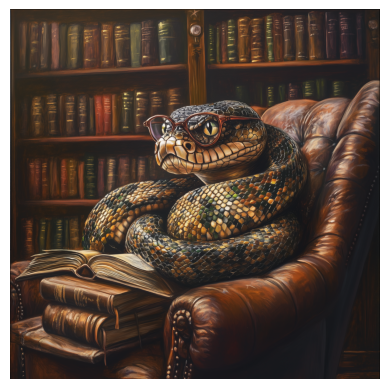

In [61]:
import matplotlib.pyplot as plt

image_url = (
    "https://github.com/mattdangerw/keras-nlp-scripts/"
    "blob/main/learned-python.png?raw=true"
)
image_path = keras.utils.get_file(origin=image_url)

image = np.array(keras.utils.load_img(image_path))
plt.axis("off")
plt.imshow(image)
plt.show()

In [62]:
gemma_lm.preprocessor.max_images_per_prompt = 1
gemma_lm.preprocessor.sequence_length = 512
prompt = "What is going on in this image? Be concise!<start_of_image>"
gemma_lm.generate({
    "prompts": PROMPT_TEMPLATE.format(prompt),
    "images": [image],
})

'<start_of_turn>user\nWhat is going on in this image? Be concise!\n\n<start_of_image>\n\n<end_of_turn>\n<start_of_turn>model\nA snake wearing glasses is sitting in a leather armchair, surrounded by a large bookshelf, and reading a book. It’s a whimsical, slightly surreal image.<end_of_turn>'

In [63]:
prompt = "What is the snake wearing?<start_of_image>"
gemma_lm.generate({
    "prompts": PROMPT_TEMPLATE.format(prompt),
    "images": [image],
})

'<start_of_turn>user\nWhat is the snake wearing?\n\n<start_of_image>\n\n<end_of_turn>\n<start_of_turn>model\nThe snake is wearing a pair of glasses! They are red-framed and perched on its head.<end_of_turn>'

##### Foundation models

#### Retrieval Augmented Generation (RAG)

#### "Reasoning" models

In [64]:
prompt = """Judy wrote a 2-page letter to 3 friends twice a week for 3 months.
How many letters did she write?
Be brief, and add "ANSWER:" before your final answer."""

gemma_lm.compile(sampler="random")

In [65]:
gemma_lm.generate(PROMPT_TEMPLATE.format(prompt))

'<start_of_turn>user\nJudy wrote a 2-page letter to 3 friends twice a week for 3 months.\nHow many letters did she write?\nBe brief, and add "ANSWER:" before your final answer.<end_of_turn>\n<start_of_turn>model\nHere\'s how to solve the problem:\n\n* **Letters per week:** 3 friends * 2 letters/week = 6 letters/week\n* **Letters per month:** 6 letters/week * 4 weeks/month = 24 letters/month\n* **Total letters:** 24 letters/month * 3 months = 72 letters\n\nANSWER: 72<end_of_turn>'

In [66]:
gemma_lm.generate(PROMPT_TEMPLATE.format(prompt))

'<start_of_turn>user\nJudy wrote a 2-page letter to 3 friends twice a week for 3 months.\nHow many letters did she write?\nBe brief, and add "ANSWER:" before your final answer.<end_of_turn>\n<start_of_turn>model\nHere\'s how to solve the problem:\n\n* **Letters per week:** She writes twice a week, so she writes 2 letters/week.\n* **Letters per month:** She writes for 3 months, so she writes 2 letters/week * 3 months * 4 weeks/month = 24 letters/month.\n* **Total letters:** She writes for 3 months, so she writes 24 letters/month * 3 months = 72 letters.\n\nANSWER: 72<end_of_turn>'

### Where are LLMs heading next?